In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/nmuller/projects/ganglion_density_sampling')
from GDS import GanglionDensitySampling
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_utils.pytorch_utils import ToOpponentChannel, ToRetinalGanglionCellSampling, convert_from_cv2_to_image, convert_from_image_to_cv2

In [2]:
# image = Image.open('/home/nmuller/projects/data/oads/oads_arw/tiff/0000018494729a82.tiff')
# image = '/home/nmuller/projects/data/oads/oads_arw/crops/ML/Tree/0c78c0b28ec120b0_3.tiff'
# image = '/home/nmuller/projects/data/oads/oads_arw/crops/ML/Van/0a3cfa7a2780c0f0_1.tiff'
image = '/home/nmuller/projects/data/oads/oads_arw/tiff/0a3cfa7a2780c0f0.tiff'

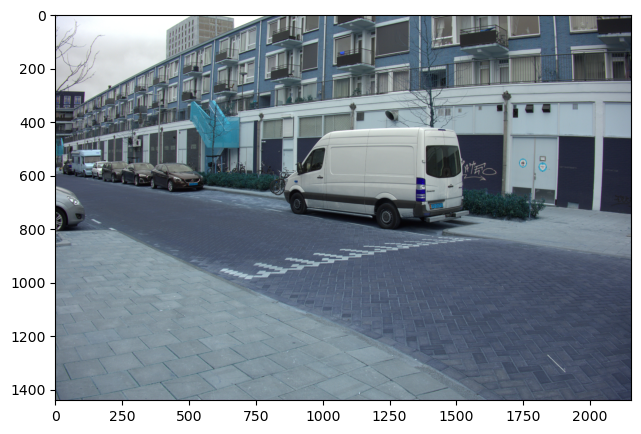

In [3]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.imshow(cv2.resize(cv2.imread(image), (2155, 1440)))

plt.show()

In [8]:
sample = Image.open('/home/nmuller/projects/data/oads/oads_arw/tiff/0000018494729a82.tiff').reduce(4)

In [9]:
sample.size

(1374, 918)

In [ ]:
sample

In [10]:
ToRGC = ToRetinalGanglionCellSampling(out_size=max(sample.size))

In [11]:
rgc = ToRGC(sample)

KeyboardInterrupt: 

# LGN Filtering

In [2]:
from oads_access.oads_access import OADS_Access
from oads_access.utils import loadmat
from pytorch_utils.pytorch_utils import ToRGBEdges
from lgnpy.CEandSC.lgn_statistics import LGN, get_field_of_view
import os

# COC Dataset mean/std

In [76]:
def mean_std_coc(tup):
    COC = ToOpponentChannel()

    coc_img = COC(tup[0])
    mean = np.mean(coc_img, axis=(0, 1))
    std = np.std(coc_img, axis=(0, 1))

    return mean, std

In [77]:
res = oads.apply_per_crop(custom_function=mean_std_coc)

100%|██████████| 18/18 [24:43<00:00, 82.44s/it] 


In [86]:
means = []
stds = []
for d, l in res.items():
    for image_name, (m, s) in l.items():
        means.append(m)
        stds.append(s)

In [99]:
print(np.mean(means, axis=0) / 255)
print(np.std(stds, axis=0) / 255)

[0.30080804 0.02202087 0.01321364]
[0.06359817 0.01878176 0.0180428 ]


# RGC Sampling

In [12]:
# image = '/home/nmuller/projects/data/oads/oads_arw/crops/ML/Van/0a3cfa7a2780c0f0_1.tiff'
image = '/home/nmuller/projects/data/oads/oads_arw/tiff/0a3cfa7a2780c0f0.tiff'
image = Image.open(image)

In [4]:
# image = image.reduce(2)
image = image.resize((2155, 1440))

In [34]:
image.size

(2155, 1440)

In [13]:
threshold_lgn_path = f'{os.path.expanduser("~")}/projects/lgnpy/ThresholdLGN.mat'
default_config_path = f'{os.path.expanduser("~")}/projects/lgnpy/lgnpy/CEandSC/default_config.yml'
threshold_lgn = loadmat(threshold_lgn_path)['ThresholdLGN']

lgn = LGN(config={'dot_pitch':0.000276, 'fov_gamma': 5, 'viewing_dist': 6}, default_config_path='/home/nmuller/projects/lgnpy/lgnpy/CEandSC/default_config.yml')

Could not load mat file with mat73 - trying to load with scipy.io.loadmat!


In [14]:
edges = ToRGBEdges(threshold_lgn=threshold_lgn, default_config_path=default_config_path)(image)

In [18]:
_x = np.abs(edges[:,:,0][imfovbeta])

In [23]:
edges[:,:,0].shape, imfovbeta.shape, np.abs(edges[:,:,0][imfovbeta]).shape

((3672, 5496), (3672, 5496), (1018093,))

In [28]:
np.array(image).shape[:2]

(1440, 2155)

In [16]:
imfovbeta, imfovgamma = get_field_of_view(lgn=lgn, imsize=np.array(image).shape[:2], viewing_dist=6)

In [17]:
imfovbeta.shape

(3672, 5496)

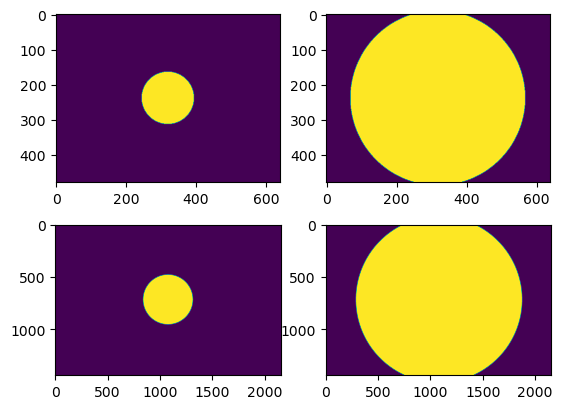

In [40]:
fig, ax = plt.subplots(2,2)

ax[0, 0].imshow(get_field_of_view(lgn= LGN(config={}, default_config_path='/home/nmuller/projects/lgnpy/lgnpy/CEandSC/default_config.yml'), imsize=(480, 640), viewing_dist=1)[0])
ax[0, 1].imshow(get_field_of_view(lgn= LGN(config={}, default_config_path='/home/nmuller/projects/lgnpy/lgnpy/CEandSC/default_config.yml'), imsize=(480, 640), viewing_dist=1)[1])
ax[1, 0].imshow(imfovbeta)
ax[1, 1].imshow(imfovgamma)

plt.show()

In [15]:
max(np.array(image).shape[:2])

2155

In [41]:
ToRGC = ToRetinalGanglionCellSampling(out_size=max(np.array(image).shape[:2])//4, series=1)
gcs_imfovbeta = ToRGC(imfovbeta)
gcs_imfovgamma = ToRGC(imfovgamma)

100%|██████████| 289444/289444 [00:25<00:00, 11279.40it/s]


In [42]:
ToRGC_image = ToRetinalGanglionCellSampling(out_size=max(np.array(image).shape)//4, series=1)
gcs_image = ToRGC_image(image)

100%|██████████| 289444/289444 [00:25<00:00, 11219.64it/s]


In [20]:
gcs_image.shape

(538, 538, 3)

In [26]:
gcs_edges = ToRGBEdges(threshold_lgn=threshold_lgn, default_config_path=default_config_path)(gcs_image)

In [24]:
gcs_edges_parvo = gcs_edges[:,:,:3]
gcs_edges_magno = gcs_edges[:,:,3:]

In [27]:
print(gcs_edges[:,:,0][gcs_imfovbeta.astype(int)].mean())
print(gcs_edges[:,:,3][gcs_imfovgamma.astype(int)].mean() / gcs_edges[:,:,3][gcs_imfovgamma.astype(int)].std())

0.0008661286158159572
0.8539042813409471


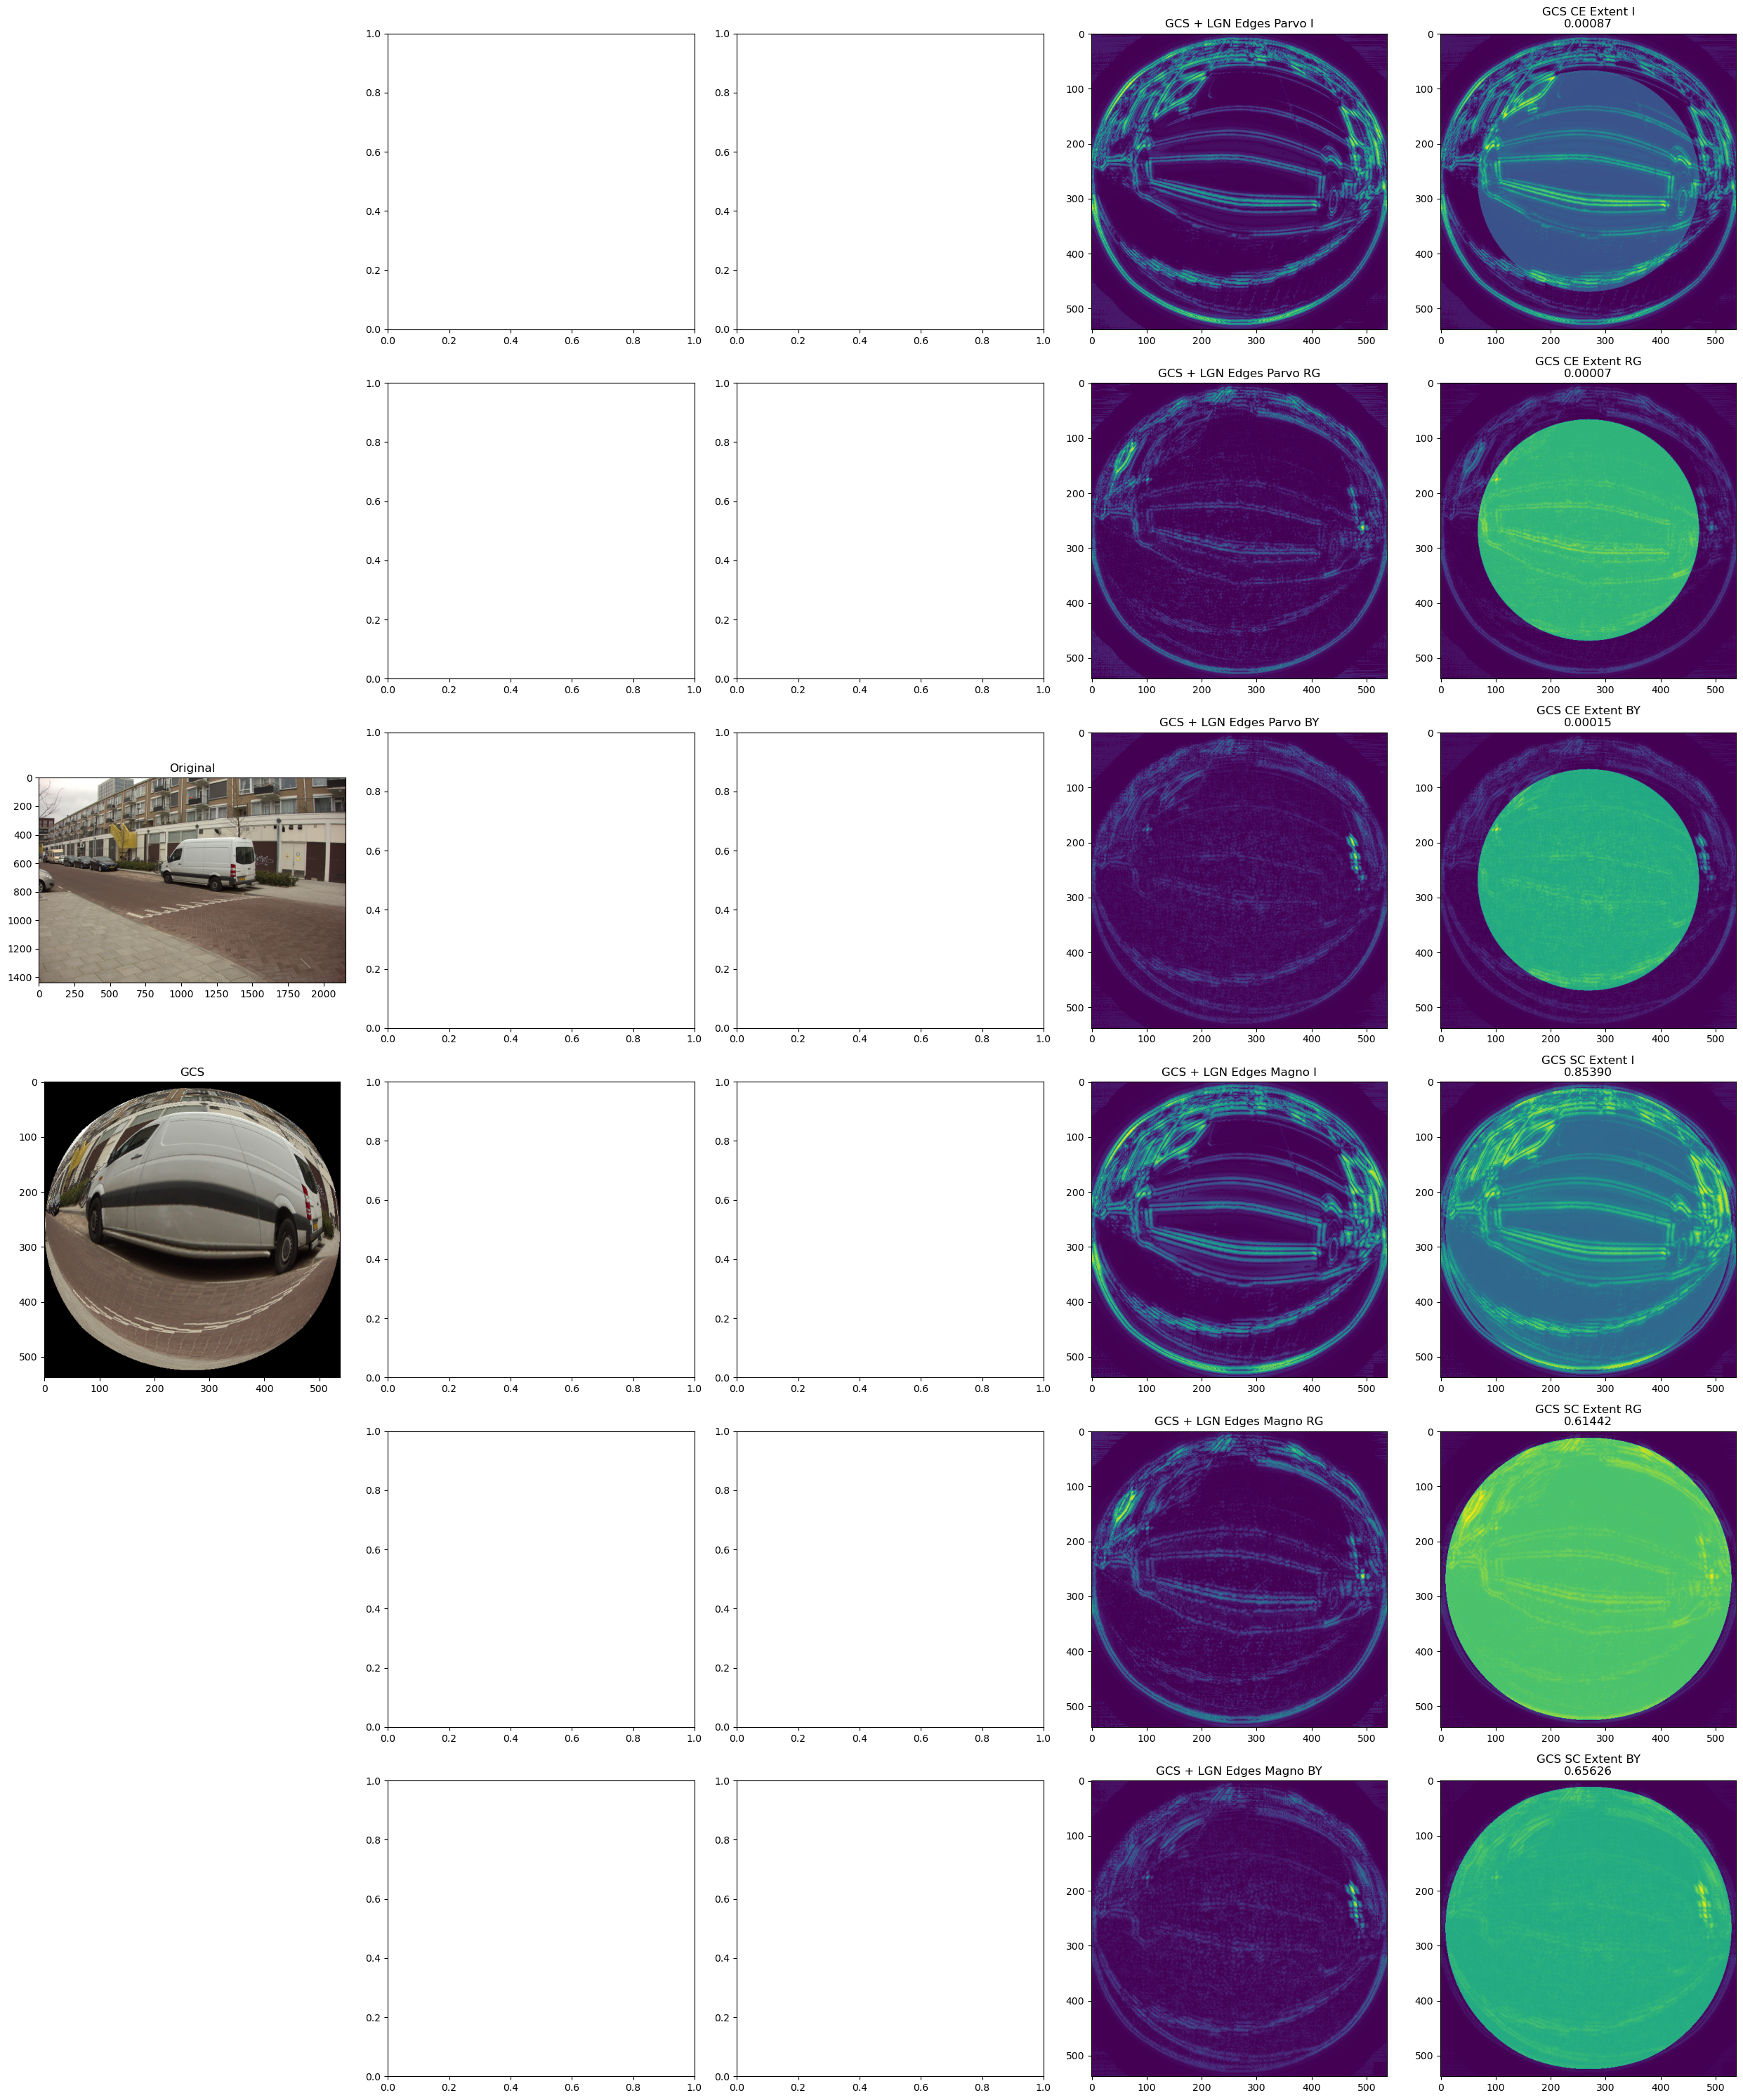

In [25]:
fig, ax = plt.subplots(6,5, figsize=(25,30))

plt.delaxes(ax[0, 0])
plt.delaxes(ax[1, 0])
# plt.delaxes(ax[3, 0])
plt.delaxes(ax[4, 0])
plt.delaxes(ax[5, 0])
ax[2, 0].imshow(image)
ax[2, 0].set_title('Original')
ax[3, 0].imshow(gcs_image)
ax[3, 0].set_title('GCS')

# ax[0, 1].imshow(edges[:,:,0])
# ax[0, 1].set_title('LGN Edges Parvo I')
# ax[1, 1].imshow(edges[:,:,1])
# ax[1, 1].set_title('LGN Edges Parvo RG')
# ax[2, 1].imshow(edges[:,:,2])
# ax[2, 1].set_title('LGN Edges Parvo BY')
# ax[3, 1].imshow(edges[:,:,3])
# ax[3, 1].set_title('LGN Edges Magno I')
# ax[4, 1].imshow(edges[:,:,4])
# ax[4, 1].set_title('LGN Edges Magno RG')
# ax[5, 1].imshow(edges[:,:,5])
# ax[5, 1].set_title('LGN Edges Magno BY')

# ax[0, 2].imshow(0.01 * imfovbeta + edges[:,:,0])
# ax[0, 2].set_title(f'CE Extent I\n{edges[:,:,0][imfovbeta].mean():.5f}')
# ax[1, 2].imshow(0.01 * imfovbeta + edges[:,:,1])
# ax[1, 2].set_title(f'CE Extent RG\n{edges[:,:,1][imfovbeta].mean():.5f}')
# ax[2, 2].imshow(0.01 * imfovbeta + edges[:,:,2])
# ax[2, 2].set_title(f'CE Extent BY\n{edges[:,:,2][imfovbeta].mean():.5f}')

# ax[3, 2].imshow(0.01 * imfovgamma + edges[:,:,3])
# ax[3, 2].set_title(f'SC Extent I\n{edges[:,:,3][imfovgamma].mean() / edges[:,:,3][imfovgamma].std():.5f}')
# ax[4, 2].imshow(0.01 * imfovgamma + edges[:,:,4])
# ax[4, 2].set_title(f'SC Extent RG\n{edges[:,:,4][imfovgamma].mean() / edges[:,:,4][imfovgamma].std():.5f}')
# ax[5, 2].imshow(0.01 * imfovgamma + edges[:,:,5])
# ax[5, 2].set_title(f'SC Extent BY\n{edges[:,:,5][imfovgamma].mean() / edges[:,:,5][imfovgamma].std():.5f}')

ax[0, 3].imshow(gcs_edges_parvo[:,:,0])
ax[0, 3].set_title(f'GCS + LGN Edges Parvo I')
ax[1, 3].imshow(gcs_edges_parvo[:,:,1])
ax[1, 3].set_title(f'GCS + LGN Edges Parvo RG')
ax[2, 3].imshow(gcs_edges_parvo[:,:,2])
ax[2, 3].set_title(f'GCS + LGN Edges Parvo BY')
ax[3, 3].imshow(gcs_edges_magno[:,:,0])
ax[3, 3].set_title(f'GCS + LGN Edges Magno I')
ax[4, 3].imshow(gcs_edges_magno[:,:,1])
ax[4, 3].set_title(f'GCS + LGN Edges Magno RG')
ax[5, 3].imshow(gcs_edges_magno[:,:,2])
ax[5, 3].set_title(f'GCS + LGN Edges Magno BY')

ax[0, 4].imshow(0.01 * gcs_imfovbeta + gcs_edges_parvo[:,:,0])
ax[0, 4].set_title(f'GCS CE Extent I\n{gcs_edges_parvo[:,:,0][gcs_imfovbeta.astype(int)].mean():.5f}')
ax[1, 4].imshow(0.01 * gcs_imfovbeta + gcs_edges_parvo[:,:,1])
ax[1, 4].set_title(f'GCS CE Extent RG\n{gcs_edges_parvo[:,:,1][gcs_imfovbeta.astype(int)].mean():.5f}')
ax[2, 4].imshow(0.01 * gcs_imfovbeta + gcs_edges_parvo[:,:,2])
ax[2, 4].set_title(f'GCS CE Extent BY\n{gcs_edges_parvo[:,:,2][gcs_imfovbeta.astype(int)].mean():.5f}')
ax[3, 4].imshow(0.01 * gcs_imfovgamma + gcs_edges_magno[:,:,0])
ax[3, 4].set_title(f'GCS SC Extent I\n{gcs_edges_magno[:,:,0][gcs_imfovgamma.astype(int)].mean() / gcs_edges_magno[:,:,0][gcs_imfovgamma.astype(int)].std():.5f}')
ax[4, 4].imshow(0.01 * gcs_imfovgamma + gcs_edges_magno[:,:,1])
ax[4, 4].set_title(f'GCS SC Extent RG\n{gcs_edges_magno[:,:,1][gcs_imfovgamma.astype(int)].mean() / gcs_edges_magno[:,:,1][gcs_imfovgamma.astype(int)].std():.5f}')
ax[5, 4].imshow(0.01 * gcs_imfovgamma + gcs_edges_magno[:,:,2])
ax[5, 4].set_title(f'GCS SC Extent BY\n{gcs_edges_magno[:,:,2][gcs_imfovgamma.astype(int)].mean() / gcs_edges_magno[:,:,2][gcs_imfovgamma.astype(int)].std():.5f}')


plt.tight_layout()
plt.show()

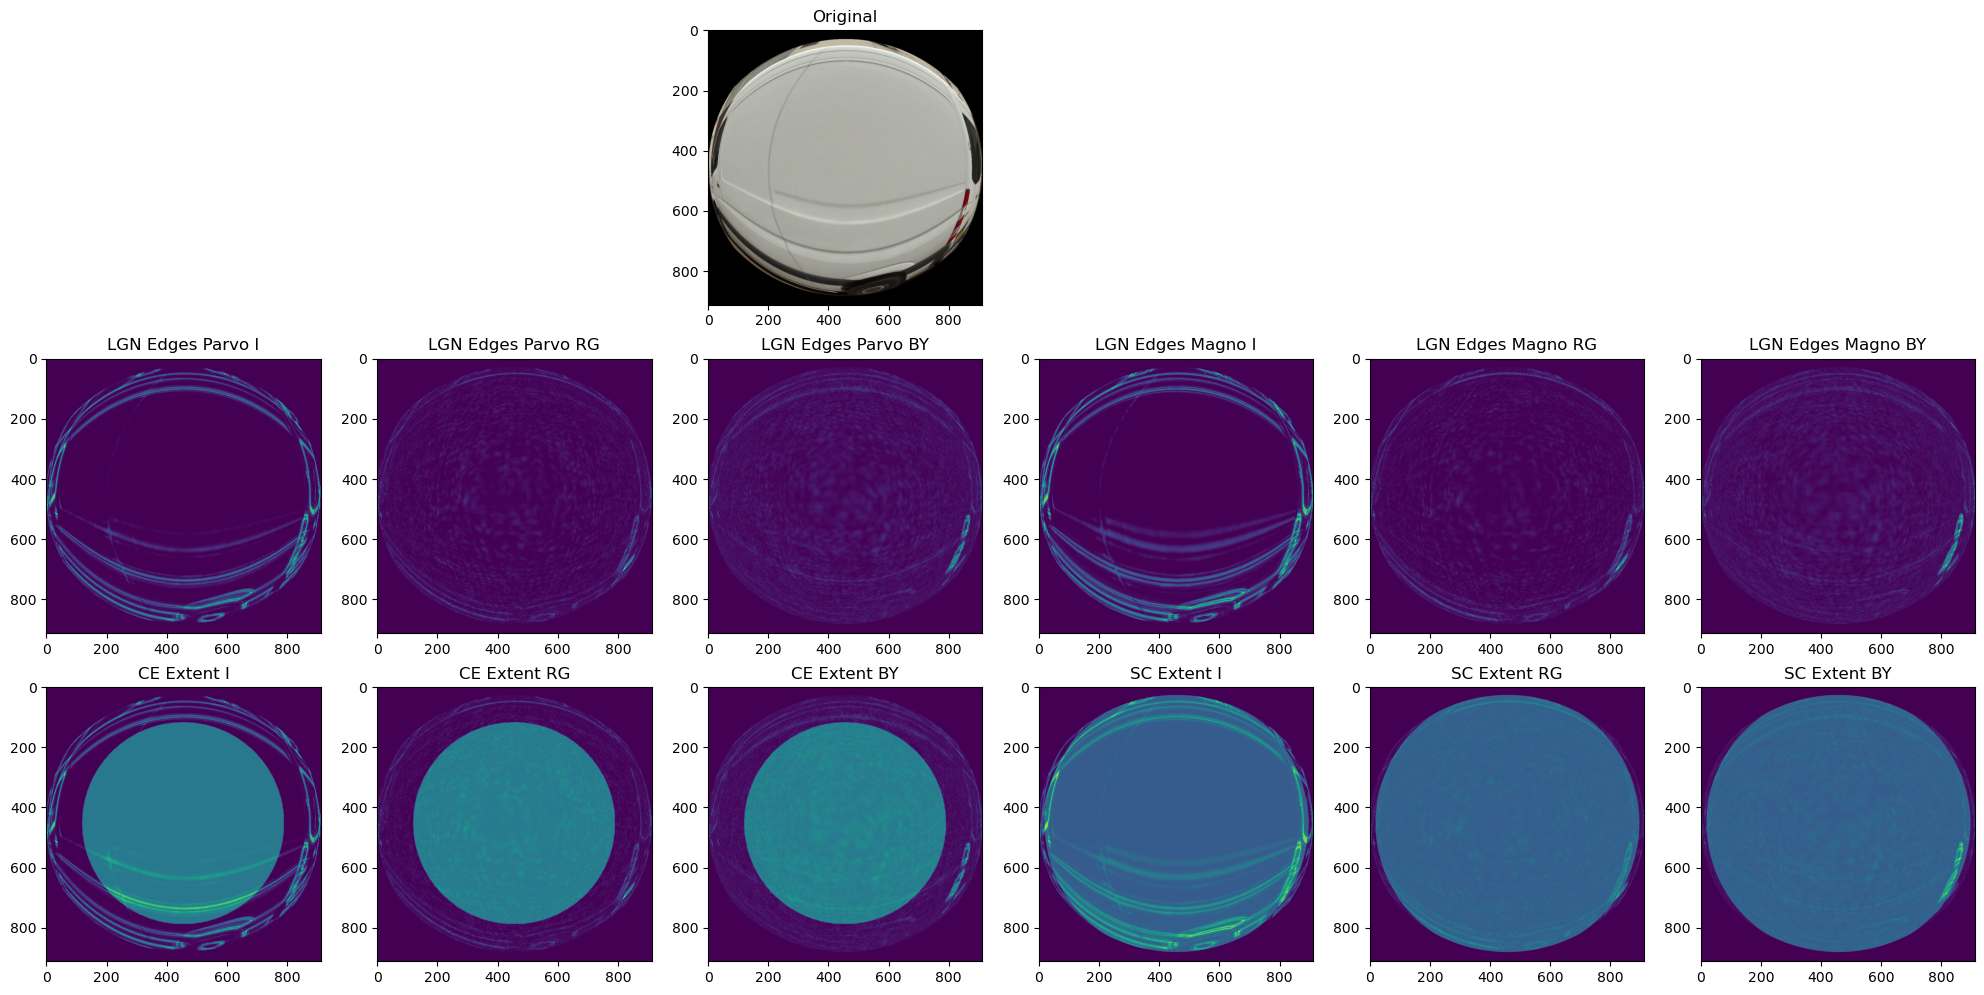

In [112]:
fig, ax = plt.subplots(3,6, figsize=(20,10))

plt.delaxes(ax[0,0])
plt.delaxes(ax[0,1])
plt.delaxes(ax[0,3])
plt.delaxes(ax[0,4])
plt.delaxes(ax[0,5])
ax[0, 2].imshow(gcs_image)
ax[0, 2].set_title('Original')

ax[1, 0].imshow(gcs_edges_parvo[:,:,0])
ax[1, 0].set_title('LGN Edges Parvo I')
ax[1, 1].imshow(gcs_edges_parvo[:,:,1])
ax[1, 1].set_title('LGN Edges Parvo RG')
ax[1, 2].imshow(gcs_edges_parvo[:,:,2])
ax[1, 2].set_title('LGN Edges Parvo BY')
ax[1, 3].imshow(gcs_edges_magno[:,:,0])
ax[1, 3].set_title('LGN Edges Magno I')
ax[1, 4].imshow(gcs_edges_magno[:,:,1])
ax[1, 4].set_title('LGN Edges Magno RG')
ax[1, 5].imshow(gcs_edges_magno[:,:,2])
ax[1, 5].set_title('LGN Edges Magno BY')

ax[2, 0].imshow(100 * gcs_imfovbeta + gcs_edges_parvo[:,:,0])
ax[2, 0].set_title('CE Extent I')
ax[2, 1].imshow(100 * gcs_imfovbeta + gcs_edges_parvo[:,:,1])
ax[2, 1].set_title('CE Extent RG')
ax[2, 2].imshow(100 * gcs_imfovbeta + gcs_edges_parvo[:,:,2])
ax[2, 2].set_title('CE Extent BY')
ax[2, 3].imshow(100 * gcs_imfovgamma + gcs_edges_magno[:,:,0])
ax[2, 3].set_title('SC Extent I')
ax[2, 4].imshow(100 * gcs_imfovgamma + gcs_edges_magno[:,:,1])
ax[2, 4].set_title('SC Extent RG')
ax[2, 5].imshow(100 * gcs_imfovgamma + gcs_edges_magno[:,:,2])
ax[2, 5].set_title('SC Extent BY')


plt.tight_layout()
plt.show()

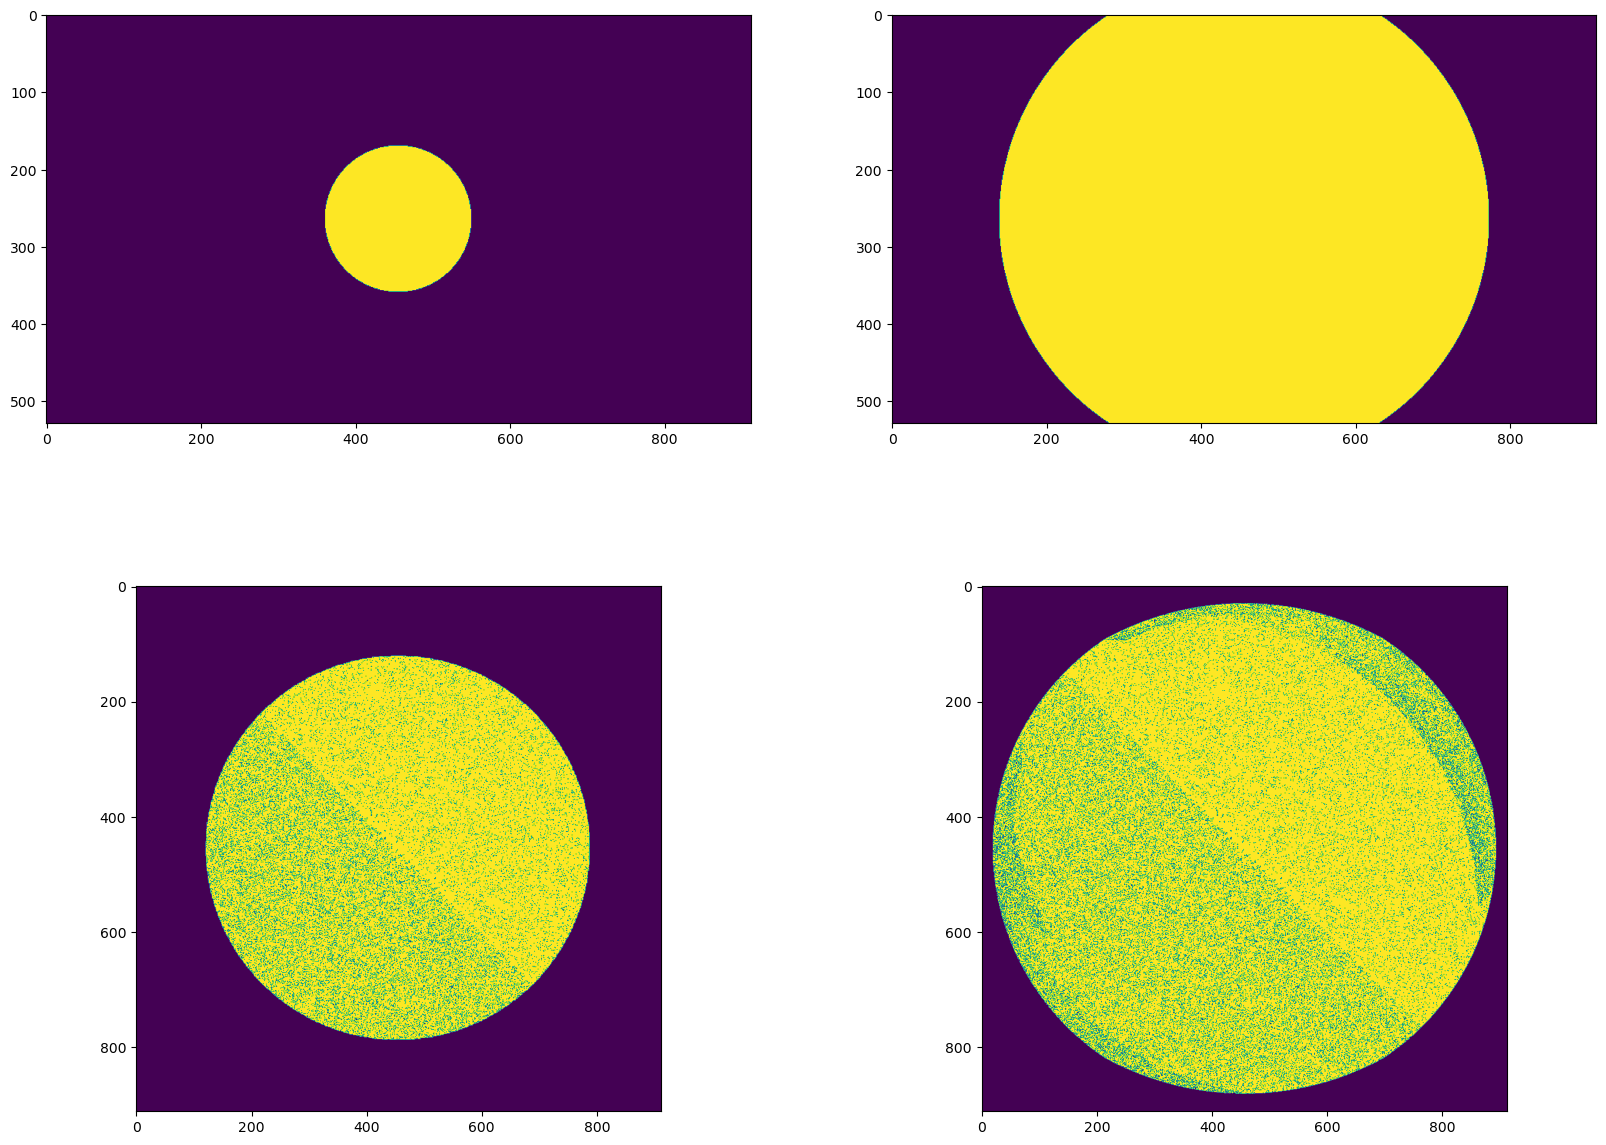

In [150]:
fig, ax = plt.subplots(2,2, figsize=(20,15))

ax[0, 0].imshow(imfovbeta)
ax[0, 1].imshow(imfovgamma)
ax[1, 0].imshow(gcs_imfovbeta.astype(int))
ax[1, 1].imshow(gcs_imfovgamma.astype(int))

plt.show()

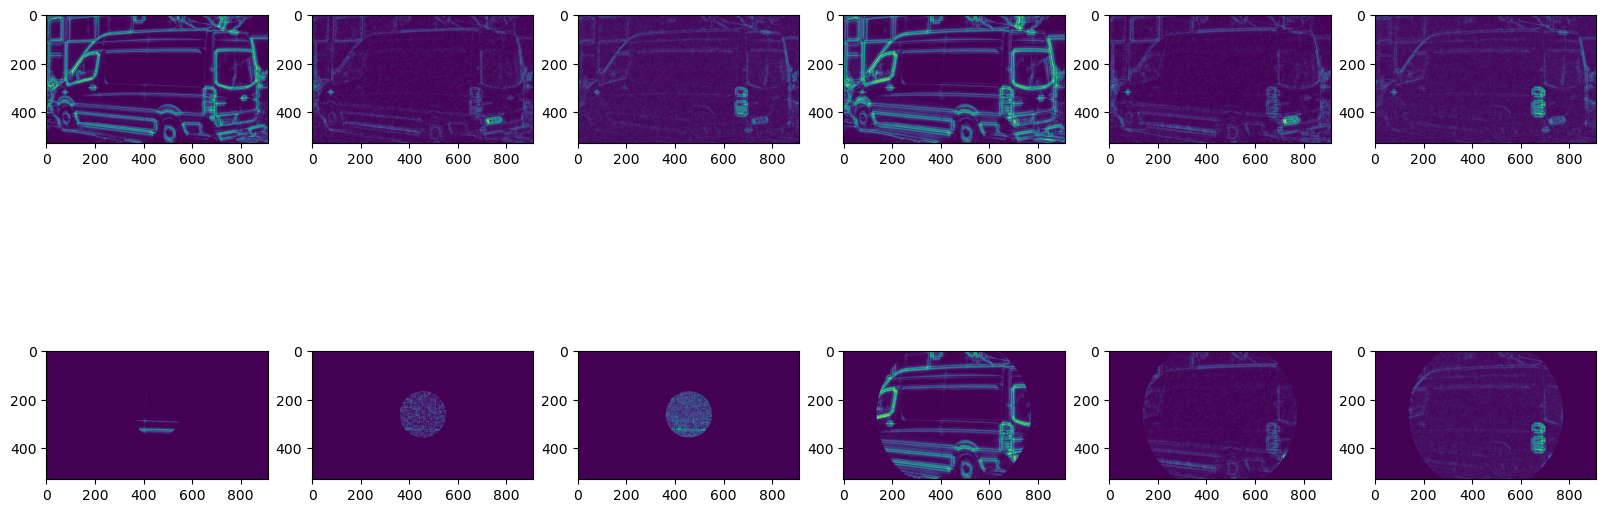

In [48]:
fig, ax = plt.subplots(2,6, figsize=(20,8))

ax[0, 0].imshow(edges[:,:,0])
ax[0, 1].imshow(edges[:,:,1])
ax[0, 2].imshow(edges[:,:,2])
ax[0, 3].imshow(edges[:,:,3])
ax[0, 4].imshow(edges[:,:,4])
ax[0, 5].imshow(edges[:,:,5])

ax[1, 0].imshow(np.where(imfovbeta, edges[:,:,0], 0) )
ax[1, 1].imshow(np.where(imfovbeta, edges[:,:,1], 0) )
ax[1, 2].imshow(np.where(imfovbeta, edges[:,:,2], 0) )
ax[1, 3].imshow(np.where(imfovgamma, edges[:,:,3], 0) )
ax[1, 4].imshow(np.where(imfovgamma, edges[:,:,4], 0) )
ax[1, 5].imshow(np.where(imfovgamma, edges[:,:,5], 0) )

plt.show()

In [5]:
image_ids = []
for image_name, info in oads.image_names.items():
    # if len(dataset_names) > 0 and info['dataset_name'] not in dataset_names:
    #     continue
    for index, _ in oads.image_names[image_name]['object_labels'].items():
            image_ids.append((image_name, index))

image_ids = list(set(image_ids))

In [13]:
ToEdges = ToRGBEdges(threshold_lgn=threshold_lgn, default_config_path=default_config_path)

In [28]:
import tqdm
import numpy as np
import os

In [27]:
crop_dir = '/home/nmuller/projects/data/oads/oads_arw/crops/ML_edges'

In [30]:
for image_id in tqdm.tqdm(image_ids):
    image_name, index = image_id
    (img, obj) = oads.load_crop_from_image(image_name=image_name, index=index)
    class_name = obj['classTitle']
    edges = ToEdges(img)

    os.makedirs(os.path.join(crop_dir, class_name), exist_ok=True)

    np.save(os.path.join(crop_dir, class_name, f'{image_name}_{index}.npy'), arr=edges, allow_pickle=True)

  0%|          | 38/86428 [01:03<40:17:44,  1.68s/it] 


KeyboardInterrupt: 